In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

df_fatores = pd.read_csv("Fatores.csv", sep=",", header=0)
df_relacao_fatores = pd.read_csv("relacao_fatores.csv", sep=",", header=0)

In [2]:
df_fatores_causa = df_fatores.loc[
    (df_fatores['Categoria'] == 'Fator Externo')
    | (df_fatores['Categoria'] == 'Qualitativo'), 'Fator'].values.tolist()


# df_fatores.head()

In [3]:
import pandas as pd

# --- normalização leve ---
def norm(s): 
    return ' '.join(str(s).strip().split()).replace('\n', ' ')

df_fatores = df_fatores.copy()
df_fatores['Fator'] = df_fatores['Fator'].map(norm)
df_fatores['Artigo'] = df_fatores['Artigo'].str.strip()

df_relacao_fatores = df_relacao_fatores.copy()
df_relacao_fatores.rename(columns={df_relacao_fatores.columns[0]: 'Fatores'}, inplace=True)
df_relacao_fatores['Fatores'] = df_relacao_fatores['Fatores'].map(norm)
df_relacao_fatores.columns = [c if c=='Fatores' else norm(c) for c in df_relacao_fatores.columns]

# dicionário fator -> artigo ("o"/"a")
artigos = df_fatores.set_index('Fator')['Artigo'].to_dict()

# matriz M com índice = fatores e colunas = fatores (alinhadas e no MESMO conjunto)
M = df_relacao_fatores.set_index('Fatores')
M = M.loc[:, [c for c in M.columns if c in M.index]]  # interseção para garantir igualdade

# --- gera perguntas só onde há "sim" no triângulo inferior ---
df_perguntas = pd.DataFrame(columns=['f1', 'f2', 'pergunta'])
for i, f1 in enumerate(M.index):
    for j, f2 in enumerate(M.columns):
        if j >= i:                   # pula diagonal e triângulo superior
            continue
        if str(M.iat[i, j]).strip().lower() == 'sim':
            a1 = artigos.get(f1, '')
            a2 = artigos.get(f2, '')
            
            # adiciona pergunta (f1 influencia f2)
            if (f2 not in df_fatores_causa) and (f1 != 'Sucesso do Lançamento'):
                df_perguntas = pd.concat([df_perguntas, pd.DataFrame({
                    'f1': f1, 
                    'f2': f2, 
                    'pergunta': f"O quanto **{a1} {f1}** influencia **{a2} {f2}**?"
                }, index=[0])], ignore_index=True)

            # adiciona pergunta (f2 influencia f1)
            if f1 not in df_fatores_causa and (f2 != 'Sucesso do Lançamento'):
                df_perguntas = pd.concat([df_perguntas, pd.DataFrame({
                    'f1': f2, 
                    'f2': f1, 
                    'pergunta': f"O quanto **{a2} {f2}** influencia **{a1} {f1}**?"
                }, index=[0])], ignore_index=True)


df_perguntas.shape
df_perguntas = (df_perguntas
        .merge(df_fatores[['Fator', 'Ordem']], left_on='f1', right_on='Fator')
        .drop(columns=['Fator'])
        .merge(df_fatores[['Fator', 'Ordem']], left_on='f2', right_on='Fator', suffixes=('_f1', '_f2'))
        .drop(columns=['Fator'])
        .sort_values(by=['Ordem_f1', 'Ordem_f2'])
        .reset_index(drop=True))

In [4]:
df_perguntas['id'] = 'P' + (df_perguntas.index + 1).map(lambda x: f'{x:02d}')
print(df_perguntas.head().to_markdown())
df_perguntas.to_markdown('perguntas.md', index=False)


|    | f1                      | f2                                                   | pergunta                                                                                                      |   Ordem_f1 |   Ordem_f2 | id   |
|---:|:------------------------|:-----------------------------------------------------|:--------------------------------------------------------------------------------------------------------------|-----------:|-----------:|:-----|
|  0 | Documentação de Projeto | Volume da Câmara                                     | O quanto **a Documentação de Projeto** influencia **o Volume da Câmara**?                                     |          1 |          6 | P01  |
|  1 | Documentação de Projeto | Razão de mistura O/F e controle de vazão do oxigênio | O quanto **a Documentação de Projeto** influencia **a Razão de mistura O/F e controle de vazão do oxigênio**? |          1 |          7 | P02  |
|  2 | Documentação de Projeto | Temperatura do Oxigênio            

# Buscando as respostas do Sheets

In [5]:
import pandas as pd
import numpy as np
from datetime import date

import gspread
from google.cloud import bigquery
from google.oauth2.service_account import Credentials


# Inicializar o cliente do BigQuery
client = bigquery.Client()

# Define the scope for the Google Sheets API
scope = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive',
]

# Create a credentials instance from a service account file
import google.auth
creds, project = google.auth.default(scopes=scope)

# Open the Google Spreadsheet
gc = gspread.authorize(creds)
spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1utzXUl0Kr405S1simj41rLYMAmFKOlA16SSejq1ELbQ/edit?resourcekey=&gid=859696412#gid=859696412')

In [6]:
sheet = spreadsheet.worksheet('export')

df_respostas = pd.DataFrame(sheet.get_all_records())
df_respostas

# faça um regex para manter apenas as colunas de perguntas (P##)
cols_manter = [x for x in df_respostas.columns if pd.Series(x).str.contains(r'^P\d+$').any()]

df_respostas = df_respostas[cols_manter].copy()
df_respostas[cols_manter] = df_respostas[cols_manter].apply(pd.to_numeric, errors='coerce')

df_silvs = df_respostas.iloc[0, :].copy()
df_silvs

df_respostas

,P01,P02,P03,P04,P05,P06,P07,P08,P09,P10,...,P41,P42,P43,P44,P45,P46,P47,P48,P49,P50
0,2.0,2.0,3.0,3.0,2.0,4.0,0.0,0.0,0.0,1.0,...,2.0,0.0,1,4.0,0.0,0.0,4.0,0.0,0.0,1.0
1,3.0,3.0,3.0,3.0,2.0,4.0,2.0,3.0,3.0,2.0,...,1.0,0.0,2,2.0,3.0,2.0,0.0,0.0,0.0,3.0
2,3.0,3.0,3.0,3.0,2.0,3.0,0.0,0.0,2.0,0.0,...,1.0,1.0,0,2.0,1.0,4.0,3.0,0.0,1.0,2.0
3,3.0,3.0,2.0,3.0,NaN,2.0,1.0,3.0,1.0,3.0,...,0.0,0.0,0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
4,4.0,4.0,1.0,4.0,NaN,4.0,2.0,1.0,2.0,1.0,...,NaN,NaN,0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,3.0,NaN,3,2.0,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,4.0,4.0,4.0,3.0,2.0,2.0,1.0,3.0,1.0,...,0.0,0.0,3,4.0,4.0,1.0,4.0,2.0,0.0,3.0
7,4.0,4.0,0.0,2.0,0.0,NaN,1.0,1.0,0.0,3.0,...,3.0,0.0,2,NaN,0.0,0.0,NaN,0.0,2.0,NaN
8,0.0,0.0,0.0,0.0,0.0,4.0,2.0,3.0,2.0,2.0,...,4.0,3.0,4,3.0,NaN,3.0,3.0,0.0,2.0,4.0
9,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,...,2.0,0.0,2,NaN,1.0,1.0,4.0,0.0,0.0,1.0


In [7]:
df_respostas.melt(var_name='Pergunta', value_name='Valor')

,Pergunta,Valor
0,P01,2.0
1,P01,3.0
2,P01,3.0
3,P01,3.0
4,P01,4.0
...,...,...
495,P50,NaN
496,P50,3.0
497,P50,NaN
498,P50,4.0


In [8]:
# Cria uma versão "long" dos dados de respostas
df_melt = df_respostas.melt(var_name='Pergunta', value_name='Valor')

# Calcula a contagem de cada resposta por pergunta e a proporção
df_counts = df_melt.groupby(['Pergunta', 'Valor']).size().reset_index(name='count')
df_totals = df_melt.groupby('Pergunta').size().reset_index(name='total')
df_counts = df_counts.merge(df_totals, on='Pergunta')
df_counts['proportion'] = df_counts['count'] / df_counts['total']

# Cria o gráfico de barras empilhadas para visualizar a proporção de respostas diferentes por pergunta
fig = px.bar(
    df_counts,
    x='Pergunta',
    y='proportion',
    color='Valor',
    title='Proporção de respostas por pergunta',
    labels={'proportion': 'Proporção', 'Valor': 'Resposta'},
    barmode='stack',
    color_continuous_scale=[(0.0, '#8B0000'), (1.0, 'green')],
    range_color=[0, 4]
)

df_media = df_respostas[cols_manter].mean().reset_index()
# fig.add_trace(px.line(df_media, x='index', y=0, title='Média das Respostas').data[0])

fig.show()

## Conferindo respostas e montando matriz do DEMATEL

In [30]:
df_respostas.melt(var_name='Pergunta', value_name='Valor')

,Pergunta,Valor
0,P01,2.0
1,P01,3.0
2,P01,3.0
3,P01,3.0
4,P01,4.0
...,...,...
495,P50,NaN
496,P50,3.0
497,P50,NaN
498,P50,4.0


In [35]:
df_fatores['cross_join_key'] = 1
df_esqueleto = df_fatores.merge(df_fatores, on='cross_join_key', how='left', suffixes=('_f1', '_f2'))

df_esqueleto = df_esqueleto.loc[df_esqueleto['Fator_f1'] != df_esqueleto['Fator_f2'], ['Fator_f1', 'Fator_f2']].copy()

df_esqueleto = df_esqueleto.merge(
    df_perguntas[['f1', 'f2', 'id']],
    left_on=['Fator_f1', 'Fator_f2'],
    right_on=['f1', 'f2'],
    how='left'
).drop(columns=['f1', 'f2'])

df_esqueleto


df_esqueleto['resposta_silvs'] = df_esqueleto.merge(
    df_silvs.rename_axis('Pergunta').reset_index(name='resposta_silvs'),
    left_on='id',
    right_on='Pergunta',
    how='left'
)['resposta_silvs']


df_esqueleto[['resposta_media', 'desvio_respostas']] = df_esqueleto.merge(
    df_respostas.melt(var_name='Pergunta', value_name='Valor').groupby('Pergunta').agg(
        resposta_media = ('Valor', 'mean'), 
        desvio_respostas = ('Valor', 'std') 
        
        ),
    left_on='id',
    right_on='Pergunta',
    how='left'
)[['resposta_media', 'desvio_respostas']]


df_esqueleto[['resposta_silvs', 'resposta_media']] = df_esqueleto[['resposta_silvs', 'resposta_media']].fillna(0)

df_esqueleto['diff'] = abs(df_esqueleto['resposta_silvs'] - df_esqueleto['resposta_media'])
print(df_esqueleto.loc[~df_esqueleto['id'].isna()].sort_values('desvio_respostas', ascending=False).to_markdown(index=False))

| Fator_f1                                             | Fator_f2                                             | id   |   resposta_silvs |   resposta_media |   desvio_respostas |     diff |
|:-----------------------------------------------------|:-----------------------------------------------------|:-----|-----------------:|-----------------:|-------------------:|---------:|
| Razão de mistura O/F e controle de vazão do oxigênio | Temperatura do Oxigênio                              | P28  |                0 |         1.55556  |           1.74005  | 1.55556  |
| Temperatura Ambiente                                 | Volume da Câmara                                     | P45  |                0 |         1.25     |           1.48805  | 1.25     |
| Temperatura Ambiente                                 | Temperatura do Oxigênio                              | P47  |                4 |         2.75     |           1.48805  | 1.25     |
| Documentação de Projeto                              

### Conclusões que foram pensadas aqui

1. As respostas não foram muito diferentes das minhas repostas, o que possivelmente indica que:

    a. não seriam necessários tantos inputs (especialistas reponsdendo o forms)

    b. Existe um consenso na avaliação

2. A variância entre as repostas pode indicar que algumas perguntas não ficaram tão claras, ou que ficaram vagas, em que há mais de uma interpretação possível cuja resposta de influência é diferente. 

    a. Estas podem ser preocupantes para o LLM
    
    b. Estas podem não ser úteis para o médodo considerando que vai ser necessário definir CTPs para elas


# Método DEMATEL

### Passo 1: Definir a matriz de relações diretas (A)

In [10]:
fatores = df_fatores.sort_values(by='Ordem')['Fator'].values.tolist()
print(fatores)
A_silvs = np.zeros((len(fatores), len(fatores)))
A_media = np.zeros((len(fatores), len(fatores)))
# A_professor = np.zeros((len(fatores), len(fatores)))


df_esqueleto['Fator_f1'] = pd.Categorical(df_esqueleto['Fator_f1'], categories=fatores, ordered=True)
df_esqueleto['Fator_f2'] = pd.Categorical(df_esqueleto['Fator_f2'], categories=fatores, ordered=True)

A_silvs = df_esqueleto.pivot(index='Fator_f1', columns='Fator_f2', values='resposta_silvs').fillna(0).values
A_media = df_esqueleto.pivot(index='Fator_f1', columns='Fator_f2', values='resposta_media').fillna(0).values
# A_professor = df_esqueleto.pivot(index='Fator_f1', columns='Fator_f2', values='resposta_professor').fillna(0).values
A_silvs

['Documentação de Projeto', 'Experiência da Equipe', 'Qualidade da Comunicação', 'Disponibilidade de Tempo', 'Orçamento Disponível', 'Volume da Câmara', 'Razão de mistura O/F e controle de vazão do oxigênio', 'Temperatura do Oxigênio', 'Massa de Parafina', 'Acabamento Superficial do Grão e pureza da parafina', 'Temperatura Ambiente', 'Sucesso do Lançamento']


array([[0., 0., 0., 0., 0., 2., 2., 3., 3., 2., 0., 4.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 0., 4.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 4.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 2.],
       [0., 0., 0., 0., 0., 0., 3., 4., 4., 4., 0., 4.],
       [0., 0., 0., 0., 0., 0., 2., 0., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 3., 0., 0., 2., 0., 2.],
       [0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 4.],
       [0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

| Fator                                                |         R-C |      R+C |
|:-----------------------------------------------------|------------:|---------:|
| Documentação de Projeto                              |  0.686955   | 0.686955 |
| Experiência da Equipe                                |  0.340037   | 0.340037 |
| Qualidade da Comunicação                             |  0.243013   | 0.243013 |
| Disponibilidade de Tempo                             |  0.309423   | 0.309423 |
| Orçamento Disponível                                 |  0.821973   | 0.821973 |
| Volume da Câmara                                     |  0.00512385 | 0.458305 |
| Razão de mistura O/F e controle de vazão do oxigênio | -0.502022   | 0.741408 |
| Temperatura do Oxigênio                              | -0.318505   | 0.49631  |
| Massa de Parafina                                    | -0.157264   | 0.835201 |
| Acabamento Superficial do Grão e pureza da parafina  | -0.437834   | 0.999194 |
| Temperatura Am

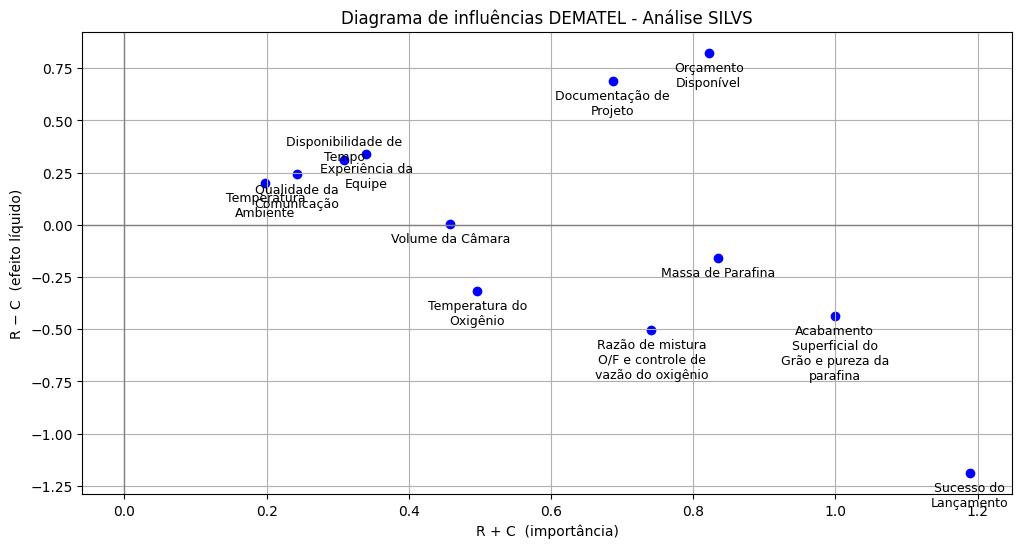

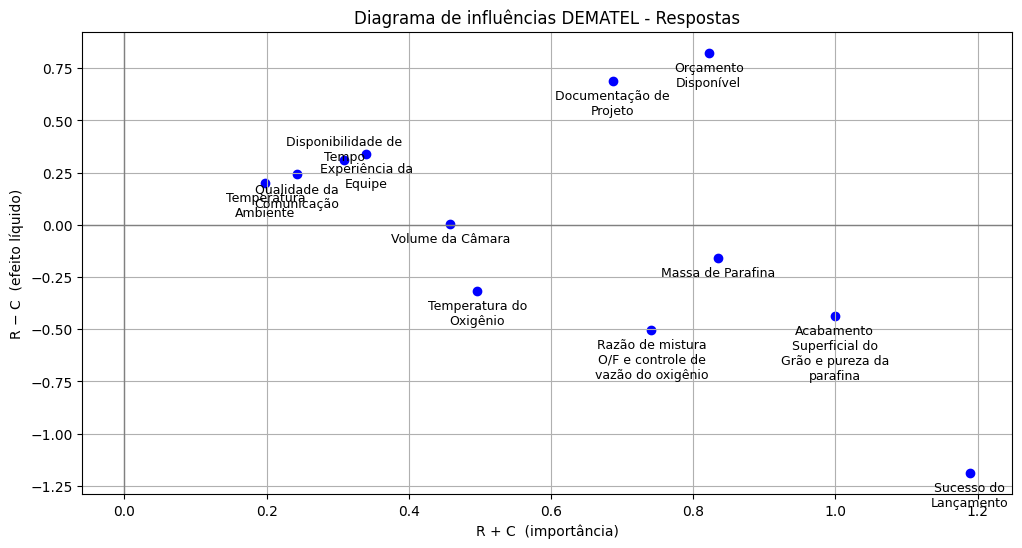

In [37]:
import textwrap

# ---------- PASSO 2: normalização (M) e matriz de relação total (T) -----
def _dematel(A, verbose=False) -> None:
    
    n = A.shape[0]
    
    row_sums = A.sum(axis=1)
    col_sums = A.sum(axis=0)
    k = min(1/row_sums.max(), 1/col_sums.max())
    M = A * k
    T = M @ np.linalg.inv(np.eye(n) - M)
    R = T.sum(axis=1)            # influência exercida
    C = T.sum(axis=0)            # influência recebida
    rc_diff = R - C
    rc_sum = R + C
    
    if verbose:
        df_print = pd.DataFrame(
            data = {
                "Fator": fatores, 
                "R-C":rc_diff, 
                "R+C":rc_sum
                }
        )
        print(df_print.to_markdown(index=False))

    return T



# __________ Gráfico DEMATEL __________
def plot_influence_diagram(T, factors, title="Diagrama de influências DEMATEL"):
    """
    Cria um gráfico de dispersão usando matplotlib.
    x: R + C (importância/prominence)
    y: R - C (efeito líquido)
    O tamanho de cada ponto é proporcional a R+C.
    """
    import matplotlib.pyplot as plt

    # Calculando parâmetros
    R = T.sum(axis=1)  # influência exercida
    C = T.sum(axis=0)  # influência recebida
    rc_sum = R + C
    rc_diff = R - C

    x = rc_sum  # Prominence
    y = rc_diff # Net effect
    sizes = (x - x.min()) / (x.max() - x.min() + 1e-9) * 2000 + 300

    # Função para quebrar o texto
    def _wrap(label, width=18):
        label = ' '.join(label.split())
        return label if len(label) <= width else '\n'.join(textwrap.wrap(label, width=width))

    wrapped_factors = [_wrap(f, width=18) for f in factors]

    # Criação do gráfico
    fig, ax = plt.subplots(figsize=(12,6))
    scatter = ax.scatter(x, y, 
                        #  s=sizes, 
                         color='blue', alpha=1)

    # Adiciona rótulos aos pontos
    for i, txt in enumerate(wrapped_factors):
        # Rótulo acima do ponto sem sobreposição
        if not hasattr(ax, "_placed_labels"):
            ax._placed_labels = []
        range_x = (x.max() - x.min()) or 1.0
        range_y = (y.max() - y.min()) or 1.0
        dx_tol = 0.035 * range_x      # tolerância horizontal para colisão
        dy_tol = 0.05 * range_y       # tolerância vertical para colisão
        base_offset = 0.02 * range_y  # deslocamento vertical incremental
        label_y = y[i] - base_offset
        # Eleva o rótulo enquanto houver interseção aproximada
        while any(abs(x[i] - px) < dx_tol and abs(label_y - py) < dy_tol for px, py in ax._placed_labels):
            label_y += base_offset
        ax.annotate(
            txt,
            (x[i], label_y),
            fontsize=9,
            ha='center',
            va='top'
        )
        ax._placed_labels.append((x[i], label_y))

    # Linhas de referência em x=0 e y=0
    ax.axhline(0, color='gray', linewidth=1)
    ax.axvline(0, color='gray', linewidth=1)

    ax.set_xlabel("R + C  (importância)")
    ax.set_ylabel("R − C  (efeito líquido)")
    ax.set_title(title)
    ax.grid(True)

    plt.show()
    
    
    
plot_influence_diagram(
    _dematel(A_silvs, True),
    fatores,
    title="Diagrama de influências DEMATEL - Análise SILVS"
)
plot_influence_diagram(
    _dematel(A_silvs),
    fatores,
    title="Diagrama de influências DEMATEL - Respostas"
)



In [12]:
import itertools
from networkx.algorithms.cycles import find_cycle
import numpy as np
import networkx as nx

def ensure_dag(G):
    """
    Remove arestas até que o grafo fique acíclico (mantém as de maior peso).
    """
    G = G.copy()
    # Tenta usar nx.find_cycle; fallback para import direto se não existir
    try:
        find_cycle_func = nx.find_cycle
    except AttributeError:
        from networkx.algorithms.cycles import find_cycle as find_cycle_func

    while True:
        try:
            cycle_edges = find_cycle_func(G, orientation="original")
        except nx.exception.NetworkXNoCycle:
            break
        # remove a aresta de menor peso no ciclo
        min_edge = min(
            cycle_edges,
            key=lambda e: G.get_edge_data(e[0], e[1]).get("weight", 1)
        )
        G.remove_edge(*min_edge[:2])
    return G

def build_graph(
    T: np.ndarray,
    factors: list[str],
    rc_sum: np.ndarray,
    threshold: float | None = None,
    include_weights: bool = True,
    enforce_dag: bool = False,
    numeric_filter: bool = False
) -> nx.DiGraph:
    """
    Constrói grafo dirigido a partir da matriz total DEMATEL T.

    Parâmetros
    ----------
    T : np.ndarray
        Matriz de relação total (n x n).
    factors : list[str]
        Nomes dos fatores (len == n).
    rc_sum : np.ndarray
        Vetor R + C (prominence) para cada fator (len == n).
    threshold : float | None
        Limite mínimo do peso (se None usa média de T).
    include_weights : bool
        Se True armazena pesos reais; senão usa peso = 1.
    enforce_dag : bool
        Se True remove ciclos.
    numeric_filter : bool
        Aplica filtro adicional usando mediana de rc_sum e (μ + 0.5σ) de T.

    Retorna
    -------
    nx.DiGraph
        Grafo de influências filtrado.
    """
    n = len(factors)
    if threshold is None:
        threshold = T.mean()

    if numeric_filter:
        prom_threshold = np.percentile(rc_sum, 50)
        edge_threshold = T.mean() + 0.5 * T.std()
    else:
        prom_threshold = edge_threshold = None

    G = nx.DiGraph()
    G.add_nodes_from(factors)

    for i, j in itertools.product(range(n), repeat=2):
        if i == j:
            continue
        w_val = T[i, j]
        if w_val <= threshold:
            continue
        if numeric_filter:
            if not (rc_sum[i] > prom_threshold and w_val > edge_threshold):
                continue
        w = round(w_val, 3) if include_weights else 1
        G.add_edge(factors[i], factors[j], weight=w)

    if enforce_dag:
        print("Enforcing DAG...")
        G = ensure_dag(G)

    return G


T = _dematel(A_silvs)[1]
G = build_graph(
    T,
    fatores,
    _dematel(A_silvs)[4],
    threshold=None,
    include_weights=True,
    enforce_dag=False,
    numeric_filter=True
)
print(f"G: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
def plot_influence_diagram(G, title="Rede Bayesiana"):
    # Use a spring layout to position the nodes
    pos = nx.spring_layout(G, seed=42)
    
    # Build trace for edges
    edge_x = []
    edge_y = []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=2, color='#888'),
        hoverinfo='none',
        mode='lines'
    )
    
    # Build trace for nodes with labels
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=[node for node in G.nodes()],
        textposition="top center",
        marker=dict(color='lightblue', size=20, line_width=2),
        hoverinfo='text'
    )
    
    # Create figure layout
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=title,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))
    fig.show()


# Plote G
import plotly.graph_objects as go
plot_influence_diagram(G, title="Rede de Influência dos Fatores (Silvs)")

In [ ]:
import networkx as nx
import pandas as pd

def plot_network(
    G,
    rc_sum,
    rc_diff,
    node_size_scale: float = 50.0,
    edge_width_scale: float = 3.0,
    title: str | None = None,
    hierarchical: bool = True,
    hierarchical_pos_fn=None,
):
    import plotly.graph_objects as go

    # Define pos usando layout hierárquico (via função passada) ou spring_layout
    if hierarchical:
        if hierarchical_pos_fn is not None:
            pos = hierarchical_pos_fn(G)
        else:
            pos = nx.spring_layout(G, seed=42)
    else:
        pos = nx.spring_layout(G, seed=42)
    nx.set_node_attributes(G, pos, "pos")

    # Cria DataFrame de nós
    node_df = pd.DataFrame(
        {
            "factor": list(G.nodes()),
            "x": [pos[n][0] for n in G.nodes()],
            "y": [pos[n][1] for n in G.nodes()],
            "RC_sum": rc_sum,
            "RC_diff": rc_diff,
        }
    )

    fig = go.Figure()

    # 1) Relações bidirecionais → linha vermelha sem seta
    drawn_pairs = set()
    for u, v in G.edges():
        if (v, u) in G.edges() and (v, u) not in drawn_pairs:
            fig.add_trace(
                go.Scatter(
                    x=[pos[u][0], pos[v][0]],
                    y=[pos[u][1], pos[v][1]],
                    mode="lines",
                    line=dict(width=edge_width_scale, color="red"),
                    hoverinfo="none",
                    showlegend=False,
                )
            )
            drawn_pairs.add((u, v))
            drawn_pairs.add((v, u))

    # 2) Relações unilaterais → seta preta
    bbox = {}  # guarda meio-largura e meio-altura de cada nó
    shapes = []
    text_traces = []
    for _, row in node_df.iterrows():
        txt = row["factor"]
        x, y = row["x"], row["y"]

        # dimensões com padding generoso
        txt_len = len(str(txt))
        pad = 0.02
        w = 0.01 + txt_len * 0.008 + pad
        h = 0.1 + pad
        bbox[txt] = (w / 2, h / 2)

        shapes.append(
            dict(
                type="rect",
                x0=x - w / 2,
                x1=x + w / 2,
                y0=y - h / 2,
                y1=y + h / 2,
                line=dict(color="rgba(60,60,60,0.9)", width=1.5),
                fillcolor="rgba(52,152,219,0.85)",
                layer="below",
            )
        )

        text_traces.append(
            go.Scatter(
                x=[x],
                y=[y],
                text=[txt],
                mode="text",
                textfont=dict(color="white", size=14, family="Arial"),
                hoverinfo="skip",
                showlegend=False,
            )
        )

    for u, v, d in G.edges(data=True):
        if (v, u) in G.edges():  # já tratada como bidirecional
            continue
        w = d.get("weight", 1)
        ux, uy = pos[u]
        vx, vy = pos[v]
        dx, dy = vx - ux, vy - uy

        # Ajusta a saída do nó de origem até a borda do retângulo
        sx = hw_u = bbox[u][0] / abs(dx) if dx else float("inf")
        sy = hh_u = bbox[u][1] / abs(dy) if dy else float("inf")
        t_u = min(sx, sy, 1)
        ox = ux + dx * t_u
        oy = uy + dy * t_u

        # Ajusta o ponto de chegada até a borda do nó destino
        scale_x = bbox[v][0] / abs(dx) if dx else float("inf")
        scale_y = bbox[v][1] / abs(dy) if dy else float("inf")
        t_v = min(scale_x, scale_y) - 0.01  # pequeno deslocamento para sair do nó
        tx = vx - dx * t_v
        ty = vy - dy * t_v

        fig.add_trace(
            go.Scatter(
                x=[ox, tx],
                y=[oy, ty],
                mode="lines",
                line=dict(width=w * edge_width_scale, color="black"),
                hoverinfo="none",
                showlegend=False,
            )
        )
        fig.add_annotation(
            x=tx,
            y=ty,
            ax=ox,
            ay=oy,
            xref="x",
            yref="y",
            axref="x",
            ayref="y",
            showarrow=True,
            arrowhead=3,
            arrowsize=2.5,
            arrowwidth=w * edge_width_scale,
            arrowcolor="black",
        )

    # Adiciona os textos e shapes
    for tr in text_traces:
        fig.add_trace(tr)
    fig.update_layout(shapes=shapes)

    fig.update_layout(
        showlegend=False,
        title=title or "Topologia DEMATEL‑LLM (DAG)",
        plot_bgcolor="#f7f9fc",
        height=800,
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()


plot_network(
    G,
    _dematel(A_silvs)[4],
    _dematel(A_silvs)[5],
    node_size_scale=50.0,
    edge_width_scale=3.0,
    title="Topologia DEMATEL‑LLM (DAG)",
    hierarchical=True,
    hierarchical_pos_fn=None,
)

# Classe Dematel

In [ ]:
import networkx as nx

class Dematel:
    def __init__(
        self,
        factors: list[str],
    ):
        """
        Parameters
        ----------
        factors : list[str]
            Lista de fatores que irão compor a matriz DEMATEL.
        provider : {"openai", "gemini"}
            Provedor de LLM; default vem de `DEFAULT_PROVIDER`.
        api_key : str | None
            Chave da API; se None, é lida das variáveis de ambiente.
        model : str | None
            Nome do modelo; se None, usa o default do provedor.
        cache : dict | None
            Cache opcional para evitar consultas repetidas à LLM.
        """
        self.cache = cache or {}


        # Atributos de domínio DEMATEL -------------------
        self.factors = factors
        self.n = len(factors)
        self.A = np.zeros((self.n, self.n), dtype=float)

        # --- Pipeline DEMATEL ---------------------------
        self._build_direct_matrix()
        self._dematel()
        self.G = self._build_graph(numeric_filter=True)

  
    def _build_direct_matrix(self) -> None:
        
        for i, src in enumerate(self.factors):
            for j, tgt in enumerate(self.factors):
                if i == j: continue
                self.A[i, j] = self._ask_llm(src, tgt)
        
        print('Matriz formada:', self.A)

    # ---------- PASSO 2: normalização (M) e matriz de relação total (T) -----
    def _dematel(self) -> None:
        row_sums = self.A.sum(axis=1)
        col_sums = self.A.sum(axis=0)
        k = min(1/row_sums.max(), 1/col_sums.max())
        self.M = self.A * k
        self.T = self.M @ np.linalg.inv(np.eye(self.n) - self.M)
        self.R = self.T.sum(axis=1)            # influência exercida
        self.C = self.T.sum(axis=0)            # influência recebida
        self.rc_sum = self.R + self.C
        self.rc_diff= self.R - self.C

    # ---------- util: garante que o grafo seja DAG -----------------
    def _ensure_dag(self, G: nx.DiGraph) -> nx.DiGraph:
        """
        Remove arestas até que o grafo fique acíclico.
        Estratégia: enquanto houver ciclo, encontra um deles e
        remove a aresta de menor peso no ciclo.
        """
        G = G.copy()
        try:
            find_cycle = nx.find_cycle  # networkx ≥ 3
        except AttributeError:
            from networkx.algorithms.cycles import find_cycle  # retro‑compat

        while True:
            try:
                cycle_edges = find_cycle(G, orientation="original")
            except nx.exception.NetworkXNoCycle:
                break  # já é DAG
            # menor peso dentro do ciclo
            min_edge = min(
                cycle_edges,
                key=lambda e: G.get_edge_data(e[0], e[1]).get("weight", 1)
            )
            G.remove_edge(*min_edge[:2])
        return G

    # ---------- util: layout hierárquico (top‑down) -----------------
    def _hierarchical_pos(self, G: nx.DiGraph, layer_gap: float = 0.25) -> dict:
        """
        Retorna um dicionário {nó: (x, y)} onde y decresce de 0 para -1
        conforme a profundidade no DAG. Usado para plotar pais acima dos filhos.
        """
        # nível (profundidade) de cada nó = distância máxima até uma raiz
        roots = [n for n, d in G.in_degree() if d == 0] or list(G.nodes())
        level = {root: 0 for root in roots}
        for node in nx.topological_sort(G):
            for child in G.successors(node):
                level[child] = max(level.get(child, 0), level[node] + 1)

        # nós por nível
        max_level = max(level.values())
        nodes_by_lvl = {l: [n for n, lv in level.items() if lv == l]
                        for l in range(max_level + 1)}

        pos = {}
        for l, nodes in nodes_by_lvl.items():
            # x espaçado uniformemente em cada nível
            if len(nodes) == 1:
                xs = [0.5]
            else:
                xs = np.linspace(0.1, 0.9, len(nodes))
            y = -l * layer_gap
            for x, n in zip(xs, nodes):
                pos[n] = (x, y)
        return pos

    # ---------- PASSO 3: constrói grafo usando threshold --------------------
    def _build_graph(self,
                 threshold: float | None = None,
                 include_weights: bool = True,
                 enforce_dag: bool = True,
                 numeric_filter: bool = False) -> nx.DiGraph:
        if threshold is None:
            threshold = self.T.mean()          # heurística simples
        G = nx.DiGraph()
        G.add_nodes_from(self.factors)
        # --- Filtro DEMATEL numérico opcional ---------------------------
        if numeric_filter:
            prom_threshold = np.percentile(self.rc_sum, 50)
            # mantém arestas cujo peso esteja acima de (μ + 0.5·σ)
            edge_threshold = self.T.mean() + 0.5 * self.T.std()
        else:
            prom_threshold = None
            edge_threshold = None
            
            
        for i, j in itertools.product(range(self.n), repeat=2):
            if i == j:
                continue
            if self.T[i, j] <= threshold:
                continue
            if numeric_filter:
                # só mantém se nó de origem é proeminente E peso é alto
                if not (self.rc_sum[i] > prom_threshold and self.T[i, j] > edge_threshold):
                    continue
            # passou em todos os filtros → adiciona aresta
            w = round(self.T[i, j], 3) if include_weights else 1
            G.add_edge(self.factors[i], self.factors[j], weight=w)
        if enforce_dag:
            G = self._ensure_dag(G)
        return G

    # ---------- PASSO 4: plota em plotly express ----------------------------
    def plot(
        self,
        node_size_scale: float = 50.0,
        edge_width_scale: float = 3.0,
        title: str | None = None,
        hierarchical: bool = True,
    ):
        if hierarchical:
            pos = self._hierarchical_pos(self.G)
        else:
            pos = nx.spring_layout(self.G, seed=42)
        nx.set_node_attributes(self.G, pos, "pos")

        # -----------------------------------------
        # DataFrame de nós
        node_df = pd.DataFrame(
            {
                "factor": list(self.G.nodes()),
                "x": [pos[n][0] for n in self.G.nodes()],
                "y": [pos[n][1] for n in self.G.nodes()],
                "RC_sum": self.rc_sum,
                "RC_diff": self.rc_diff,
            }
        )

        fig = go.Figure()

        # -----------------------------------------
        # 1) Relações bidirecionais → linha vermelha sem seta
        drawn_pairs = set()
        for u, v in self.G.edges():
            if (v, u) in self.G.edges() and (v, u) not in drawn_pairs:
                fig.add_trace(
                    go.Scatter(
                        x=[pos[u][0], pos[v][0]],
                        y=[pos[u][1], pos[v][1]],
                        mode="lines",
                        line=dict(width=edge_width_scale, color="red"),
                        hoverinfo="none",
                        showlegend=False,
                    )
                )
                drawn_pairs.add((u, v))
                drawn_pairs.add((v, u))

        # -----------------------------------------
        # 2) Relações unilaterais → seta preta
        bbox = {}  # guarda meio-largura e meio-altura de cada nó
        # shapes e textos também usam bbox, então preenche junto com shapes/textos
        shapes = []
        text_traces = []
        for _, row in node_df.iterrows():
            txt = row["factor"]
            x, y = row["x"], row["y"]

            # --- dimensões com padding generoso ---
            txt_len = len(txt)
            pad = 0.02
            w = 0.01 + txt_len * 0.008 + pad   # largura
            h = 0.1 + pad                     # altura
            bbox[txt] = (w / 2, h / 2)

            shapes.append(
                dict(
                    type="rect",
                    x0=x - w / 2,
                    x1=x + w / 2,
                    y0=y - h / 2,
                    y1=y + h / 2,
                    line=dict(color="rgba(60,60,60,0.9)", width=1.5),
                    fillcolor="rgba(52,152,219,0.85)",  # azul mais vibrante
                    layer="below",
                )
            )

            text_traces.append(
                go.Scatter(
                    x=[x],
                    y=[y],
                    text=[txt],
                    mode="text",
                    textfont=dict(color="white", size=14, family="Arial"),
                    hoverinfo="skip",
                    showlegend=False,
                )
            )

        for u, v, d in self.G.edges(data=True):
            if (v, u) in self.G.edges():  # já tratada como bidirecional
                continue
            w = d.get("weight", 1)
            # vetores direção
            ux, uy = pos[u]
            vx, vy = pos[v]
            dx, dy = vx - ux, vy - uy
            # desloca saída até borda do retângulo de origem
            hw_u, hh_u = bbox[u]
            sx = hw_u / abs(dx) if dx else float("inf")
            sy = hh_u / abs(dy) if dy else float("inf")
            t_u = min(sx, sy, 1)  # escalonamento máximo 1
            ox = ux + dx * t_u
            oy = uy + dy * t_u
            # desloca ponto de chegada até borda do retângulo de destino
            hw_v, hh_v = bbox[v]
            scale_x = hw_v / abs(dx) if dx else float("inf")
            scale_y = hh_v / abs(dy) if dy else float("inf")
            t_v = min(scale_x, scale_y) - 0.01  # -0.01 para garantir fora
            tx = vx - dx * t_v
            ty = vy - dy * t_v

            fig.add_trace(
                go.Scatter(
                    x=[ox, tx],
                    y=[oy, ty],
                    mode="lines",
                    line=dict(width=w * edge_width_scale, color="black"),
                    hoverinfo="none",
                    showlegend=False,
                )
            )
            fig.add_annotation(
                x=tx,
                y=ty,
                ax=ox,
                ay=oy,
                xref="x",
                yref="y",
                axref="x",
                ayref="y",
                showarrow=True,
                arrowhead=3,
                arrowsize=2.5,
                arrowwidth=w * edge_width_scale,
                arrowcolor="black",
            )

        # -----------------------------------------
        # 3) Nós como retângulos azuis (shapes/texts já preenchidos acima)
        # adiciona os textos ao gráfico
        for tr in text_traces:
            fig.add_trace(tr)
        # adicionar os shapes
        fig.update_layout(shapes=shapes)

        fig.update_layout(
            showlegend=False,
            title=title or "Topologia DEMATEL‑LLM (DAG)",
            plot_bgcolor="#f7f9fc",
        )
        fig.update_xaxes(visible=False)
        fig.update_yaxes(visible=False)
        fig.show()



def plot_influence_diagram(self, title="Diagrama de influências DEMATEL"):
    """
    Scatter (R+C  vs  R−C) com tamanho proporcional a R+C.
    R + C  → importância/prominence
    R − C  → tipo:
        positivo  → fator mais causador
        negativo → fator mais resultante
    """

    x = self.rc_sum            # Prominence
    y = self.rc_diff           # Net effect
    sizes = (x - x.min()) / (x.max() - x.min() + 1e-9) * 2000 + 300

    # Prepara os dados para o plot
    df = pd.DataFrame({
        "R_plus_C": x,
        "R_minus_C": y,
        "Factor": self.factors,
        "Size": sizes
    })

    # Formata o texto dos rótulos para múltiplas linhas se necessário
    def format_label(label):
        max_char = 1000
        return label if len(label) < max_char else "\n".join([label[i:i+max_char] for i in range(0, len(label), max_char)])
    df["Formatted_Factor"] = df["Factor"].apply(format_label)

    fig = px.scatter(
        df,
        x="R_plus_C",
        y="R_minus_C",
        size="Size",
        text="Formatted_Factor",
        title=title,
        labels={"R_plus_C": "R + C  (importância)", "R_minus_C": "R − C  (efeito líquido)"},
        size_max=60
    )
    fig.update_traces(textposition="middle center")
    
    # Adiciona linhas de referência em x=0 e y=0
    fig.add_vline(x=0, line_width=1, line_color="gray")
    fig.add_hline(y=0, line_width=1, line_color="gray")
    
    fig.update_traces(textposition='middle center')
    fig.update_layout(
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )

    
    fig.show()

# --- use dentro da classe ---
Dematel.plot_influence_diagram = plot_influence_diagram
# ------------------ EXEMPLO DE USO ------------------------------------------